# Klachten Dataset Project 1
## Data Voorbereiding 
Versie Mattijn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn import tree
from sklearn.linear_model import RidgeCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from typing import Dict, Tuple, List

In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
klachten = pd.read_csv("klachten.csv")

In [4]:
klachten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887 entries, 0 to 14886
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                14887 non-null  int64 
 1   Datum_ontvangst   14887 non-null  object
 2   Product           14887 non-null  object
 3   Omschrijving      14887 non-null  object
 4   Antwoord_bedrijf  14887 non-null  object
dtypes: int64(1), object(4)
memory usage: 581.7+ KB


## Train-Test Splits maken

In [5]:
X = klachten["Omschrijving"].astype(str)
y = klachten["Product"].astype(str)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(10420,) (4467,)
(10420,) (4467,)


## Data Processing

In [6]:
def remove_punctuation(text: str) -> str:
    """Haal leestekens weg."""
    return re.sub(r"[^\w\s]", "", text)

# stopwoordenlijst & lemmatizer als globale objecten
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def data_preprocessor(text: str) -> str:
    """Lowercase + leestekens weghalen."""
    text = text.lower()
    text = remove_punctuation(text)
    return text

def data_tokenizer(text: str):
    """
    1. Tokenizen
        2. Stopwoorden verwijderen
        3. Lemmatizen
        """
        # 1. tokenizen
    tokens = word_tokenize(text, language="english")

    # 2. stopwoorden er uit
    tokens = [t for t in tokens if t not in stop_words]

    # 3. lemmatizen (LET OP: .lemmatize, niet .lamatize)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    print(tokens)
    return tokens

In [7]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    preprocessor=data_preprocessor,
    tokenizer=data_tokenizer,
    analyzer="word",
    stop_words=None,
    token_pattern=None
)

X_train_tfidf = vectorizer.fit_transform(X_train)

print("\nVorm van de TF-IDF-matrix:", X_train_tfidf.shape)
print("Features (woorden):", vectorizer.get_feature_names_out())

['received', 'copy', 'credit', 'report', 'state', 'judgment', 'xxxx2014', 'know', 'got', 'judgement', 'never', 'given', 'notice', 'appear', 'court']
['paid', '42000', 'appraisal', 'home', 'based', 'upon', 'rate', 'originally', 'quoted', 'mortgage', 'finance', 'america', 'mortgage', 'dba', 'xxxx', 'xxxx', 'document', 'mortgage', 'provided', 'quoted', 'rate', 'higher', 'xxxx', 'elected', 'go', 'different', 'brokerlender', 'xxxx', 'division', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'requested', 'appraisal', 'transferred', 'since', 'paid', 'xxxx', 'xxxx', 'respond', 'several', 'week', 'uncooperative', 'would', 'provide', 'necessary', 'paperwork']
['transunion', 'reporting', 'xxxx', 'xxxx', 'credit', 'report', 'transaction', 'initiated', 'towed', 'vehicle', 'sold', 'transunion', 'finex', 'group', 'standing', 'reporting', 'anything', 'credit', 'report', 'since', 'initiated']
['begin', 'prior', 'entering', 'vehicle', 'loan', 'agreement', 'tdauto', 'fiance', 'conjunction', 'xxxx', 'previous', 'vehicle

### Datum exploration Grafiek

In [9]:
klachten["Datum_ontvangst"] = pd.to_datetime(klachten["Datum_ontvangst"])


Aantal klachten per dag

In [11]:
per_dag = (
    klachten
    .set_index("Datum_ontvangst") 
    .resample("D")                 
    .size()                        
    .rename("aantal_klachten")
    .reset_index()
)

Grafieken met de data

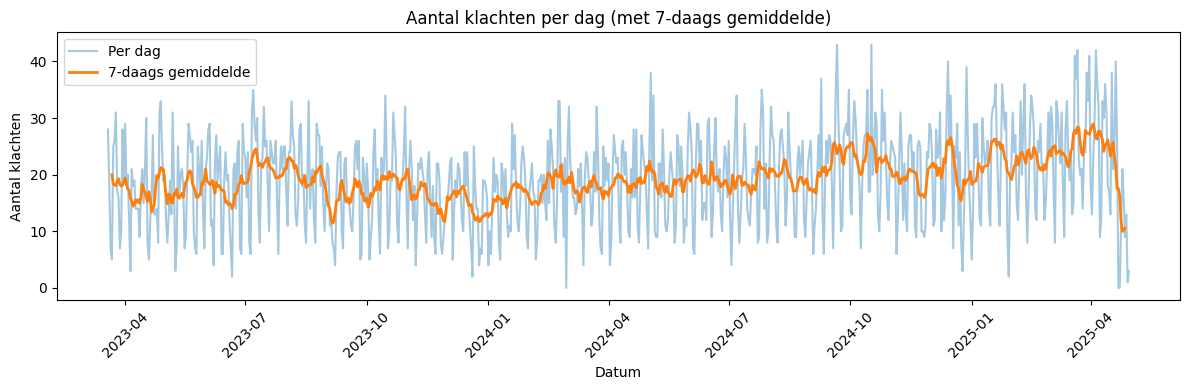

In [14]:
per_dag["rolling_7"] = per_dag["aantal_klachten"].rolling(7, center=True).mean()

plt.figure(figsize=(12, 4))
plt.plot(per_dag["Datum_ontvangst"], per_dag["aantal_klachten"], alpha=0.4, label="Per dag")
plt.plot(per_dag["Datum_ontvangst"], per_dag["rolling_7"], linewidth=2, label="7-daags gemiddelde")
plt.title("Aantal klachten per dag (met 7-daags gemiddelde)")
plt.xlabel("Datum")
plt.ylabel("Aantal klachten")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

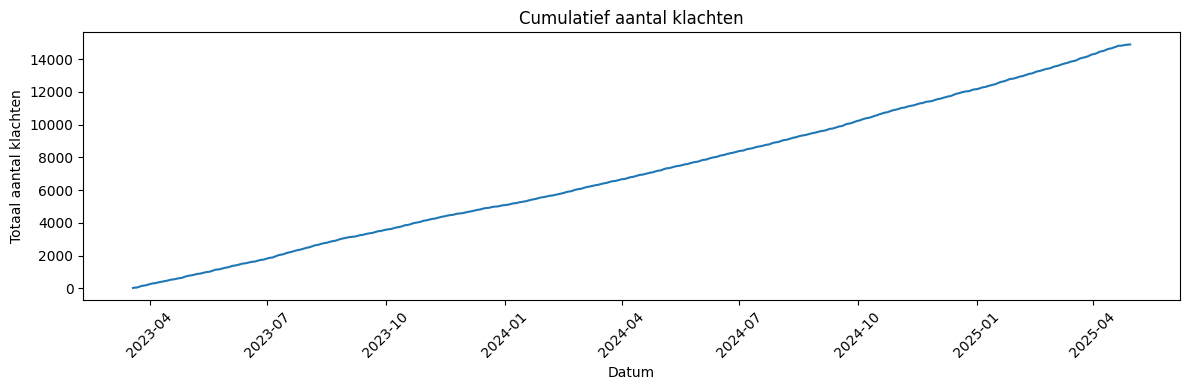

In [15]:
per_dag["cumulatief"] = per_dag["aantal_klachten"].cumsum()

plt.figure(figsize=(12, 4))
plt.plot(per_dag["Datum_ontvangst"], per_dag["cumulatief"])
plt.title("Cumulatief aantal klachten")
plt.xlabel("Datum")
plt.ylabel("Totaal aantal klachten")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
